In [1]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt

from sklearn.cluster import MiniBatchKMeans
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix

# Scene Recognition using Bag of Visual Words (BOVW)

In [2]:
# Mapping from class labels to indices
lab2ind = {
    'aquarium': 0,
    'desert': 1,
    'highway': 2,
    'kitchen': 3,
    'laundromat': 4,
    'park': 5,
    'waterfall': 6,
    'windmill': 7
}

# Mapping from indices to class labels
ind2lab = {lab2ind[lab]: lab for lab in lab2ind}

# Parameters
n_clusters = 500
C = 0.01
gamma = 0.001

In [3]:
# Returns a list of paths of all images
def get_img_paths(path):
    img_paths = []
    for folder in os.listdir(path):
        if os.path.isdir(os.path.join(path, folder)):
            for file in os.listdir(os.path.join(path, folder)):
                if not '.DS_Store' in file:
                    img_paths.append(os.path.join(path, folder, file))
    
    np.random.shuffle(img_paths)
    return img_paths

In [4]:
# Returns images, labels and descriptors given the path of the images
def get_img_details(img_paths):
    sift = cv2.SIFT_create()
    
    img_labels = []
    img_descriptors = []
    imgs = []
    
    for im_path in img_paths:
        img = cv2.imread(im_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (150, 150))
        imgs.append(img)
        
        kp, des = sift.detectAndCompute(img, None)
        img_descriptors.append(des)
        
        for i in lab2ind:
            if i in im_path:
                img_labels.append(lab2ind[i])
                break
    
    return imgs, img_labels, img_descriptors

# Returns the kmeans classifier and the image features
def vocabulary(img_descriptors, n_clusters):
    descriptors = img_descriptors[0]
    for i in img_descriptors[1:]:
        descriptors = np.vstack((descriptors, i))
        
    kmeans = MiniBatchKMeans(n_clusters=n_clusters)
    kmeans.fit(descriptors)
    
    img_features = np.zeros((len(img_descriptors), n_clusters))
    for i in range(len(img_descriptors)):
        near_clusters = kmeans.predict(img_descriptors[i])
        for j in near_clusters:
            img_features[i][j] += 1
    
    return kmeans, img_features

In [5]:
# Plots histogram given the image features
def histogram(features, n_clusters, normalize, title):
    x = np.arange(n_clusters)
    y = np.sum(features, axis=0)
    
    if normalize:
        scale = StandardScaler()
        scale.fit(features)
        features = scale.transform(features)
        y = np.sum(np.abs(features), axis=0)

    plt.bar(x, y)
    plt.xlabel('Visual word index')
    plt.ylabel('Frequency')
    plt.title(title)
    
    plt.show()

In [6]:
# Function that trains SVM on train images
def training(img_features, img_labels, C, gamma):
    svm = SVC(kernel='linear', C=C, gamma=gamma)
    svm.fit(img_features, img_labels)
    
    return svm

In [7]:
# Function that classifies test images
def classify(svm, img_descriptors, kmeans, n_clusters):
    descriptors = img_descriptors[0]
    for i in img_descriptors[1:]:
        descriptors = np.vstack((descriptors, i))
        
    img_features = np.zeros((len(img_descriptors), n_clusters))
    for i in range(len(img_descriptors)):
        near_clusters = kmeans.predict(img_descriptors[i])
        for j in near_clusters:
            img_features[i][j] += 1
          
    pred = svm.predict(img_features)
    
    return img_features, pred

In [8]:
# Function that plots confusion matrix
def plot_confusion_matrix(cm, classes, normalize):
    fig = plt.figure(figsize=(12, 8))
    axs = fig.add_subplot()
    im = axs.imshow(cm, cmap='Blues')
    axs.figure.colorbar(im)
    axs.set(xticks = np.arange(cm.shape[1]), xticklabels=classes)
    axs.set(yticks = np.arange(cm.shape[0]), yticklabels=classes)
    axs.set(xlabel ='Predicted label', ylabel = 'True label')
    if normalize:
        plt.title('Normalized confusion matrix')
    else:
        plt.title('Confusion matrix (without normalization)')
    
    tmp = '0.2f' if normalize else 'd'
    thresh = np.max(cm)/2
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            axs.text(j, i, format(cm[i, j], tmp), ha="center", va="center", color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()

    plt.show()

In [9]:
train_img_paths = get_img_paths('../dataset/SUN_data/SUN_data/train')
train_imgs, train_img_labels, train_img_descriptors = get_img_details(train_img_paths)
kmeans, train_img_features = vocabulary(train_img_descriptors, n_clusters)

## Histograms

### Without normalization (train images)

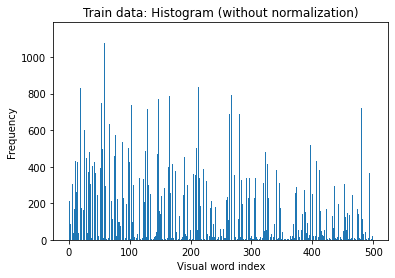

In [10]:
histogram(train_img_features, n_clusters, normalize=False, title='Train data: Histogram (without normalization)')

### With normalization (train images)

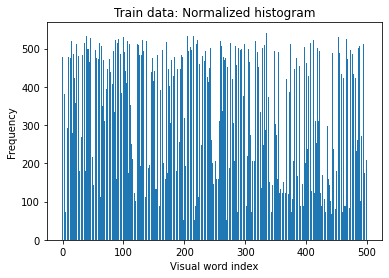

In [11]:
histogram(train_img_features, n_clusters, normalize=True, title='Train data: Normalized histogram')

### For sample image 1 (train images)

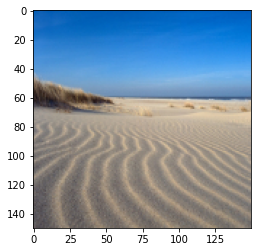

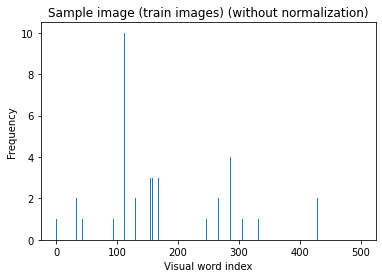

In [12]:
plt.imshow(train_imgs[0])
plt.show()

histogram(train_img_features[0:1], n_clusters, normalize=False, title='Sample image (train images) (without normalization)')

In [13]:
svm = training(train_img_features, train_img_labels, C, gamma)

In [14]:
test_img_paths = get_img_paths('../dataset/SUN_data/SUN_data/test')
test_imgs, test_img_labels, test_img_descriptors = get_img_details(test_img_paths)
test_img_features, pred_labs = classify(svm, test_img_descriptors, kmeans, n_clusters)

### Without normalization (test images)

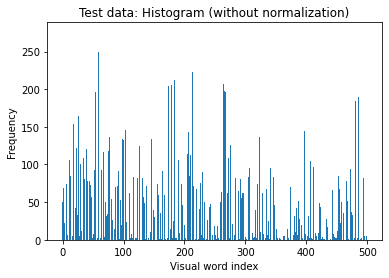

In [15]:
histogram(test_img_features, n_clusters, normalize=False, title='Test data: Histogram (without normalization)')

### With normalization (test images)

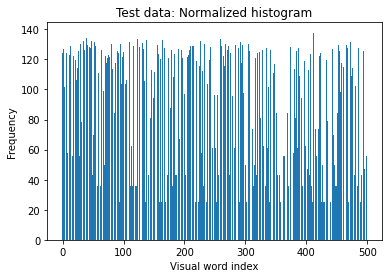

In [16]:
histogram(test_img_features, n_clusters, normalize=True, title='Test data: Normalized histogram')

### For sample image (test images)

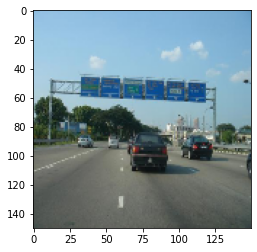

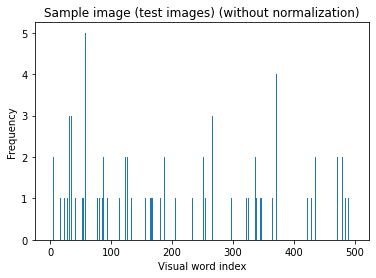

In [17]:
plt.imshow(test_imgs[0])
plt.show()

histogram(test_img_features[0:1], n_clusters, normalize=False, title='Sample image (test images) (without normalization)')

In [18]:
print('Accuracy obtained: ' + str(accuracy_score(test_img_labels, pred_labs)*100) + '%')

Accuracy obtained: 53.125%


## Sample images

In [19]:
correct_ind = np.random.choice(np.where(test_img_labels == pred_labs)[0], 5)
wrong_ind = np.random.choice(np.where(test_img_labels != pred_labs)[0], 5)

### Correctly classified images with predicted labels

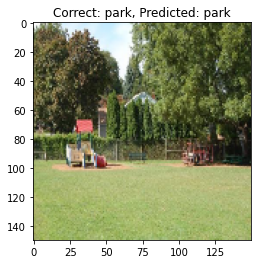

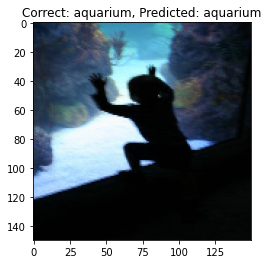

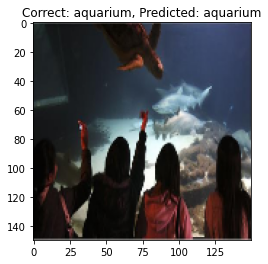

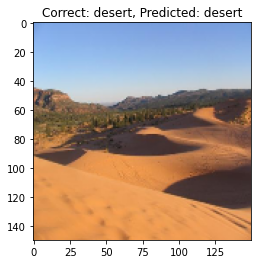

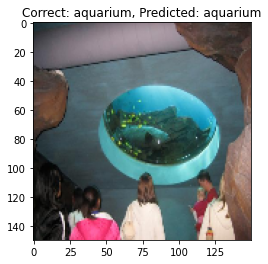

In [20]:
for ind in correct_ind:
    plt.imshow(test_imgs[ind])
    plt.title('Correct: ' + ind2lab[test_img_labels[ind]] + ', Predicted: ' + ind2lab[pred_labs[ind]])
    plt.show()

### Wrongly classified images with predicted labels

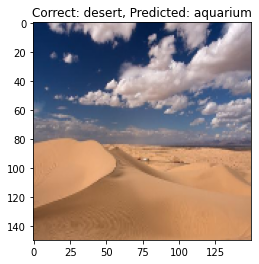

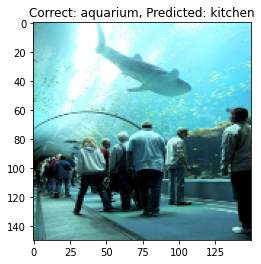

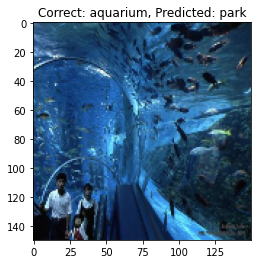

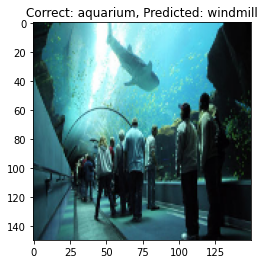

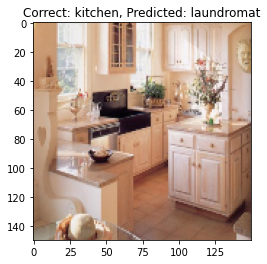

In [21]:
for ind in wrong_ind:
    plt.imshow(test_imgs[ind])
    plt.title('Correct: ' + ind2lab[test_img_labels[ind]] + ', Predicted: ' + ind2lab[pred_labs[ind]])
    plt.show()

## Confusion matrices

In [22]:
cm = confusion_matrix(test_img_labels, pred_labs)
classes = list(lab2ind.keys())

### Without normalization

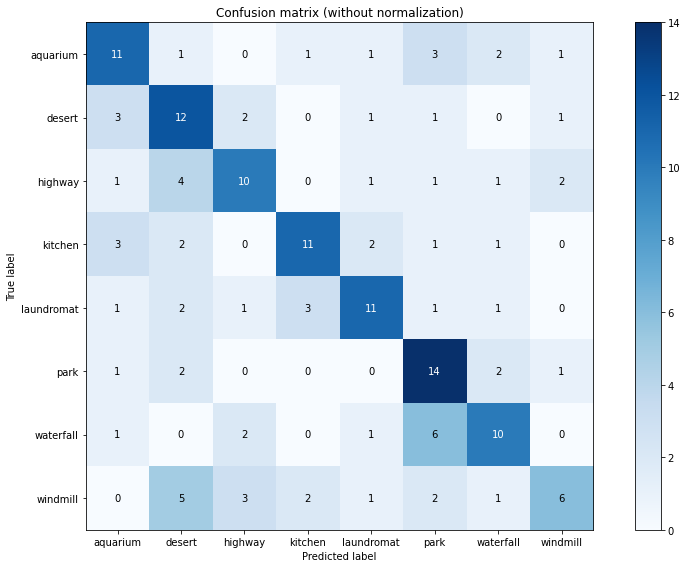

In [23]:
plot_confusion_matrix(cm, classes, False)

### With normalization

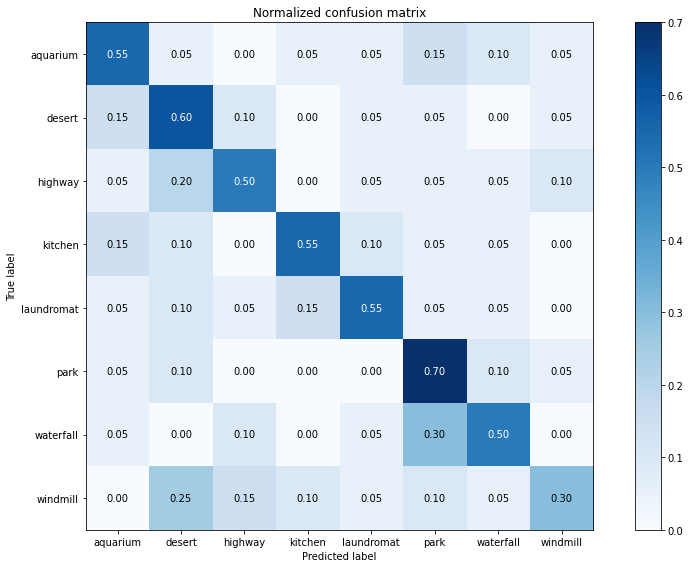

In [24]:
n_cm = cm / np.sum(cm, axis=1)[:, np.newaxis]
plot_confusion_matrix(n_cm, classes, True)